In [1]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import time
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import data
from skimage.io import imread
import sys
try:
    from localgraphclustering import *
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    from localgraphclustering import *
    
from affinity_kimon import affinity
from skimage.color import rgb2gray
from skimage import data, segmentation, color
from skimage.future import graph
from skimage.segmentation import mark_boundaries

## Load image from skimage

In [2]:
img = data.astronaut()
[m,n] = img.shape[0:2]
n_pixels = m*n

## Construct an affinity matrix using our Cython implementation in affinity_kimon. You can replace this with your own adjacency matrix. If you want to use our implementation, please remember to recompile affinity_kimon.pyx under the notebooks folder. Note that this pipeline is not the most efficient for image segmentation. This pipeline uses only colour and position cues. Our objective is to demonstrate how effective local graph clustering is.

In [3]:
data, row, col = affinity(n_pixels,m,n,80.0,7.0e+1,max(m,n)/1.0e+1,0.4,img.astype(float))
A = sp.sparse.csc_matrix((data, (row, col)), shape=(n_pixels, n_pixels))

## Load the matrix in the LocalGraphClustering API

In [4]:
g = GraphLocal.from_sparse_adjacency(A)

## Find a single segment in the image using local graph clustering. Ignore warnings about weighted graphs.

0.7222545146942139


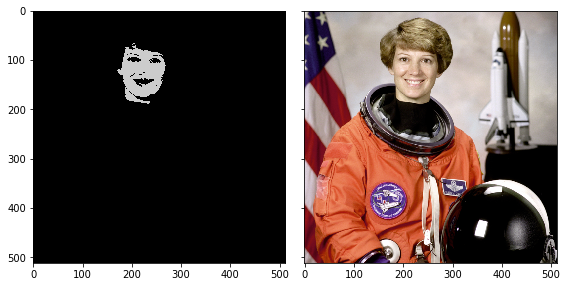

In [5]:
start = time.time()
refnode = [120*m + 220]
output = approximate_PageRank(g,refnode,method='l1reg-rand',alpha=0.03,rho=1.0e-15,normalize=False,normalized_objective=False,epsilon=1.0e-2,iterations=1000000,cpp=True) 
end = time.time()
print(end - start)

labels = np.zeros(n_pixels)
labels[output[0]] = 1

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 8))

ax[0].imshow(labels.reshape((m,n)), cmap='nipy_spectral')
ax[1].imshow(img)

#for a in ax:
    #a.axis('off')

plt.tight_layout()

## Segment the whole image using spectral local graph clustering.

In [ ]:
start = time.time()
# Compute the embeddings X and the pairwise distance matrix Z.
labels, info = graph_segmentation(g,rho_list=[1.0e-15,1.0e-1],alpha_list=[0.03,1.0e-1],iterations=1000000,ratio=0.1,nsamples_from_rho=1,nsamples_from_alpha=30,normalized_objective=False,njobs=6,how_many_in_parallel=6)
end = time.time()
print(end - start)

## Plot

In [ ]:
out_lgc = color.label2rgb(labels.reshape((m,n)), img, kind='avg')

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(13, 13))

ax[0].imshow(mark_boundaries(img, labels.reshape((m,n))))
ax[1].imshow(out_lgc)
ax[2].imshow(img)

for a in ax:
    a.axis('off')

plt.tight_layout()

## Segment the whole image using spectral + flow (MQI) local graph clustering

In [ ]:
start = time.time()
# Compute the embeddings X and the pairwise distance matrix Z.
labels, info = graph_segmentation_with_improve(g,rho_list=[1.0e-15,1.0e-1],alpha_list=[0.03,1.0e-1],iterations=1000000,ratio=0.1,nsamples_from_rho=1,nsamples_from_alpha=30,normalized_objective=False,njobs=6,how_many_in_parallel=6)
end = time.time()
print(end - start)

## Visualize the result

In [ ]:
out_lgc_with_improve = color.label2rgb(labels.reshape((m,n)), img, kind='avg')

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(13, 13))

ax[0].imshow(mark_boundaries(img, labels.reshape((m,n))))
ax[1].imshow(out_lgc_with_improve)
ax[2].imshow(img)

for a in ax:
    a.axis('off')

plt.tight_layout()

## Run the classic normalized cut from skimage

In [ ]:
labels_slic = segmentation.slic(img, n_segments=1000)
rag_ = graph.rag_mean_color(img, labels_slic, mode='similarity')
new_labels_slic = graph.cut_normalized(labels_slic, rag_, thresh=0.1, num_cuts=500)
out_ncuts = color.label2rgb(new_labels_slic, img, kind='avg')

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(13, 13))

ax[0].imshow(mark_boundaries(img, new_labels_slic))
ax[1].imshow(out_ncuts)
ax[2].imshow(img)

for a in ax:
    a.axis('off')

plt.tight_layout()

## Slice image using slic from skimage

In [ ]:
labels = segmentation.slic(img, compactness=30, n_segments=400)
out_slic = color.label2rgb(labels, img, kind='avg')

## Visualize all results

In [ ]:
fig, ax = plt.subplots(ncols=5, sharex=True, sharey=True, figsize=(20, 20))

ax[0].imshow(out_ncuts)
ax[1].imshow(out_lgc)
ax[2].imshow(out_lgc_with_improve)
ax[3].imshow(out_slic)
ax[4].imshow(img)

ax[0].set_title('Normalized Cuts')
ax[1].set_title('Local Graph Clustering')
ax[2].set_title('Local Graph Clustering with Improve')
ax[3].set_title('Skimage slicing')
ax[4].set_title('Original')

for a in ax:
    a.axis('off')

plt.tight_layout()

## Compute NCP plot

In [ ]:
import warnings
warnings.filterwarnings('ignore')

ncp_instance = NCPData(g,store_output_clusters=True,do_largest_component=False)
ncp_instance.approxPageRank(ratio=1,nthreads=6,method = "l1reg-rand")

## Make an interactive NCP

In [ ]:
p = NCPPlots(ncp_instance)
p.cond_by_size_itrv();

## Reload the data and make sure the graph is a connected component

In [ ]:
data, row, col = affinity(n_pixels,m,n,80.0,7.0e+1,max(m,n)/1.0e+1,1.0e-4,img.astype(float))
A = sp.sparse.csc_matrix((data, (row, col)), shape=(n_pixels, n_pixels))

g = GraphLocal.from_sparse_adjacency(A)

g.is_disconnected()

## Run spectral

29.51130199432373
conductance:  0.04538395514823313
Check if output of l1reg is a connected component
There are  1  connected components in the graph
The graph is not a disconnected graph.
Minimum non-zero value in adjacency:  0.40048980667901735
Maximum non-zero value in adjacency:  0.9806582491395386
Minimum non-zero value in sub-adjacency (based on output of l1reg):  0.40048980667901735
Maximum non-zero value in sub-adjacency (based on output of l1reg):  0.9806582491395386


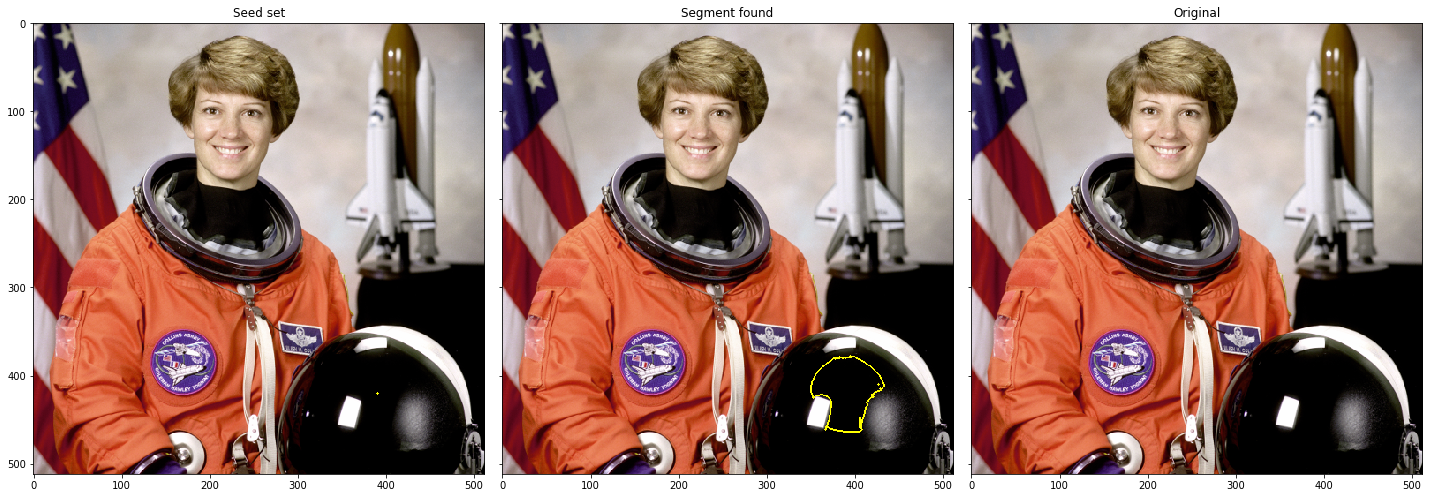

In [6]:
start = time.time()

width = 25
i = 440
j = 345

refnode = []

# for p in range(i,i+width):
    
#     for q in range(j,j+width):
        
#         refnode.append(p*n + q)

refnode = [420*n + 390]

nsamples_from_alpha = 50
alpha_list = [1.0e-2,0.8]

sampled_alphas = list(np.geomspace(alpha_list[0], alpha_list[1], nsamples_from_alpha, endpoint=True))

min_crit = 10000
min_crit_embedding = 0

for alpha in list(reversed(sampled_alphas)):

    output = approximate_PageRank(g,refnode,method='l1reg-rand',alpha=alpha,rho=1.0e-6,normalize=False,normalized_objective=False,epsilon=1.0e-2,iterations=1000000) 

    conductance = g.compute_conductance(output[0])

    crit = conductance
    if crit <= min_crit:
        min_crit = crit
        min_crit_embedding = output

end = time.time()
print(end - start)

labels_seed = np.zeros(n_pixels, dtype=np.int32)
labels_seed[refnode] = 1

labels = np.zeros(n_pixels, dtype=np.int32)
labels[min_crit_embedding[0]] = 1

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(20, 20))

ax[0].imshow(mark_boundaries(img, labels_seed.reshape((m,n)),mode='thick'))
ax[1].imshow(mark_boundaries(img, labels.reshape((m,n)),mode='thick'))
ax[2].imshow(img)

ax[0].set_title('Seed set')
ax[1].set_title('Segment found')
ax[2].set_title('Original')

# for a in ax:
#     a.axis('off')
    
plt.tight_layout()

print("conductance: ", g.compute_conductance(min_crit_embedding[0]))


A2 = g.adjacency_matrix.tocsr()[min_crit_embedding[0], :].tocsc()[:, min_crit_embedding[0]]
g_copy = GraphLocal.from_sparse_adjacency(A2)

print("Check if output of l1reg is a connected component")
g_copy.is_disconnected()

print("Minimum non-zero value in adjacency: ", A.data.min())
print("Maximum non-zero value in adjacency: ", A.data.max())

print("Minimum non-zero value in sub-adjacency (based on output of l1reg): ", A2.data.min())
print("Maximum non-zero value in sub-adjacency (based on output of l1reg): ", A2.data.max())

## Run MQI

In [7]:
output_mqi = flow_clustering(g,min_crit_embedding[0],method="mqi_weighted")

labels_mqi = np.zeros(n_pixels, dtype=np.int32)
labels_mqi[output_mqi[0]] = 1

print("Improved conductance: ", output_mqi[1])

Improved conductance:  0.04436514206125138


## Run SimpleLocal

In [8]:
output_sl = flow_clustering(g,min_crit_embedding[0],method="sl_weighted",delta=1)

labels_sl = np.zeros(n_pixels, dtype=np.int32)
labels_sl[output_sl[0]] = 1

print("Improved conductance: ", output_sl[1])

#SimpleLocal should give the same results as MQI when delta is large

output_sl = flow_clustering(g,min_crit_embedding[0],method="sl_weighted",delta=1.0e6)

labels_sl = np.zeros(n_pixels, dtype=np.int32)
labels_sl[output_sl[0]] = 1

print("Improved conductance: ", output_sl[1])

Improved conductance:  0.024772671479270893
Improved conductance:  0.04436514206125138


## Visualize the results

In [ ]:
fig, ax = plt.subplots(ncols=5, sharex=True, sharey=True, figsize=(20, 20))

ax[0].imshow(mark_boundaries(img, labels_seed.reshape((m,n)),mode='thick'))
ax[1].imshow(mark_boundaries(img, labels.reshape((m,n)),mode='thick'))
ax[2].imshow(mark_boundaries(img, labels_mqi.reshape((m,n)),mode='thick'))
ax[3].imshow(mark_boundaries(img, labels_sl.reshape((m,n)),mode='thick'))
ax[4].imshow(img)

ax[0].set_title('Seed set')
ax[1].set_title('Segment found with spectral')
ax[2].set_title('Improve segment by MQI')
ax[3].set_title('Improve segment by SimpleLocal')
ax[4].set_title('Original')

# for a in ax:
#     a.axis('off')
    
plt.tight_layout()